# libraries

In [1]:
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import *
import sys
from pathlib import Path
import re
import pandas as pd

# availability over time

In [2]:
data_dir = Path("data")
pattern = re.compile(r"^(?P<symbol>.+)-1d-(?P<ym>\d{4}-\d{2})\.zip$")

rows = []
for symbol_dir in data_dir.iterdir():
    if not symbol_dir.is_dir():
        continue
    one_d_dir = symbol_dir / "1d"
    if not one_d_dir.is_dir():
        continue
    for p in one_d_dir.iterdir():
        if not p.is_file():
            continue
        m = pattern.match(p.name)
        if not m:
            continue
        ym = m.group("ym")
        try:
            dt = datetime.strptime(ym, "%Y-%m")
        except ValueError:
            continue
        rows.append((symbol_dir.name, dt))

df = pl.DataFrame(rows, schema=["symbol", "date"]).with_columns(pl.col("date").cast(pl.Datetime))
order_df = df.group_by("symbol").agg(pl.min("date").alias("min_date")).sort("min_date")

df_pd = df.to_pandas()
df_pd["date"] = pd.to_datetime(df_pd["date"])
order = order_df.get_column("symbol").to_list()
df_pd["symbol"] = pd.Categorical(df_pd["symbol"], categories=order, ordered=True)

print(f"Symbols: {len(order)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

availability = (
    df_pd.assign(present=1)
    .pivot_table(index="symbol", columns="date", values="present", fill_value=0)
    .astype(float)
)

symbols = availability.index.to_list()
fig_height = max(12, len(symbols) * 0.12)
fig, ax = plt.subplots(figsize=(24, fig_height))
im = ax.imshow(availability.values, cmap="RdYlGn", aspect="auto", vmin=0, vmax=1)

ax.set_xlabel("Date")
ax.set_ylabel("Symbol")
ax.set_title("Availability Heatmap: 1d Monthly Files")

dates = availability.columns
n_dates_to_show = min(20, len(dates))
if n_dates_to_show > 0:
    date_indices = np.linspace(0, len(dates) - 1, n_dates_to_show, dtype=int)
    ax.set_xticks(date_indices)
    ax.set_xticklabels([dates[i].strftime("%Y-%m") for i in date_indices], rotation=45)

ax.set_yticks(range(len(symbols)))
ax.set_yticklabels(symbols, fontsize=6)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Availability (0=Missing, 1=Present)")

plt.tight_layout()
plt.show()

C:\Users\arjun\AppData\Local\Temp\ipykernel_21812\1565536974.py:24: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  df = pl.DataFrame(rows, schema=["symbol", "date"]).with_columns(pl.col("date").cast(pl.Datetime))
C:\Users\arjun\AppData\Local\Temp\ipykernel_21812\1565536974.py:37: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  .pivot_table(index="symbol", columns="date", values="present", fill_value=0)


Symbols: 3421
Date range: 2017-07-01 00:00:00 to 2025-12-01 00:00:00


# symbols overtime

C:\Users\arjun\AppData\Local\Temp\ipykernel_21812\652061868.py:5: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  pl.count().alias("months"),
C:\Users\arjun\AppData\Local\Temp\ipykernel_21812\652061868.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
(Deprecated in version 0.20.5)
  .agg(pl.count().alias("symbols"))


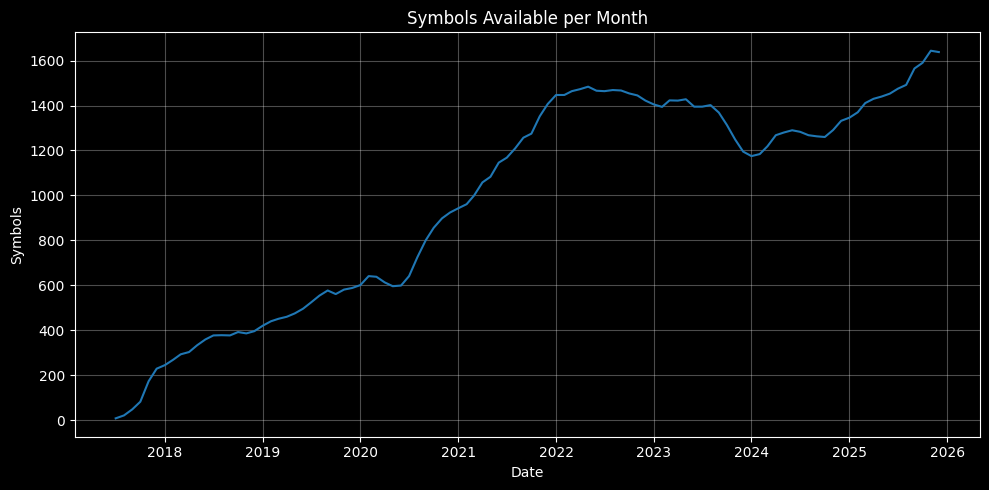

Total symbols: 3421
Overall date range: 2017-07-01 00:00:00 to 2025-12-01 00:00:00


shape: (10, 4)
┌─────────┬────────┬─────────────────────┬─────────────────────┐
│ symbol  ┆ months ┆ first_date          ┆ last_date           │
│ ---     ┆ ---    ┆ ---                 ┆ ---                 │
│ str     ┆ u32    ┆ datetime[μs]        ┆ datetime[μs]        │
╞═════════╪════════╪═════════════════════╪═════════════════════╡
│ ETHBTC  ┆ 102    ┆ 2017-07-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ NEOBTC  ┆ 102    ┆ 2017-07-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ LTCBTC  ┆ 102    ┆ 2017-07-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ BNBBTC  ┆ 102    ┆ 2017-07-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ QTUMETH ┆ 102    ┆ 2017-07-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ GASBTC  ┆ 101    ┆ 2017-08-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ BNBETH  ┆ 101    ┆ 2017-08-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ ETHUSDT ┆ 101    ┆ 2017-08-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ BTCUSDT ┆ 101    ┆ 2017-08-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ LRCETH  ┆ 100    ┆ 2017-09-01 00:00:00 ┆ 2025-12-01 00:00:00 │
└─────────┴────────┴─────────────────────┴─────────────────────┘

shape: (10, 4)
┌─────────────┬────────┬─────────────────────┬─────────────────────┐
│ symbol      ┆ months ┆ first_date          ┆ last_date           │
│ ---         ┆ ---    ┆ ---                 ┆ ---                 │
│ str         ┆ u32    ┆ datetime[μs]        ┆ datetime[μs]        │
╞═════════════╪════════╪═════════════════════╪═════════════════════╡
│ DOGEUSD1    ┆ 1      ┆ 2025-12-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ LUNAUSDC    ┆ 1      ┆ 2025-12-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ BNBBULLUSDT ┆ 1      ┆ 2020-03-01 00:00:00 ┆ 2020-03-01 00:00:00 │
│ XRPUSD1     ┆ 1      ┆ 2025-12-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ BNBUSD1     ┆ 1      ┆ 2025-12-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ ADAUSD1     ┆ 1      ┆ 2025-12-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ LUNCUSDC    ┆ 1      ┆ 2025-12-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ ZECUSD1     ┆ 1      ┆ 2025-12-01 00:00:00 ┆ 2025-12-01 00:00:00 │
│ BNBBULLBUSD ┆ 1      ┆ 2020-03-01 00:00:00 ┆ 2020-03-01 00:00:00 │
│ SOLUSD1     ┆ 1      ┆ 2025-12-01 00:00:00 ┆ 2025-12-01 00:00:00 │
└─────────────┴────────┴─────────────────────┴─────────────────────┘

In [ ]:
symbol_stats = (
    df.group_by("symbol")
    .agg(
        pl.count().alias("months"),
        pl.min("date").alias("first_date"),
        pl.max("date").alias("last_date"),
    )
    .sort("months", descending=True)
)

monthly_counts = (
    df.group_by("date")
    .agg(pl.count().alias("symbols"))
    .sort("date")
)
monthly_pd = monthly_counts.to_pandas()

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(monthly_pd["date"], monthly_pd["symbols"], color="#1f77b4")
ax.set_title("Symbols Available per Month")
ax.set_xlabel("Date")
ax.set_ylabel("Symbols")
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Total symbols:", symbol_stats.height)
print("Overall date range:", df["date"].min(), "to", df["date"].max())

display(symbol_stats.head(10))
display(symbol_stats.tail(10))


=== DATA COVERAGE ANALYSIS ===
Total symbols: 3421
Total time periods: 102
Possible symbol-month combinations: 348,942
Actual data points: 100,047
Overall data completeness: 28.67%

=== SYMBOL LIFECYCLE ANALYSIS ===
Symbols with complete data (all 102 months): 5
Symbols with single month only: 21
Average symbol lifespan: 29.2 months (2.4 years)
Median symbol lifespan: 23.0 months



C:\Users\arjun\AppData\Local\Temp\ipykernel_21812\1073129766.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(duration_data, labels=years)


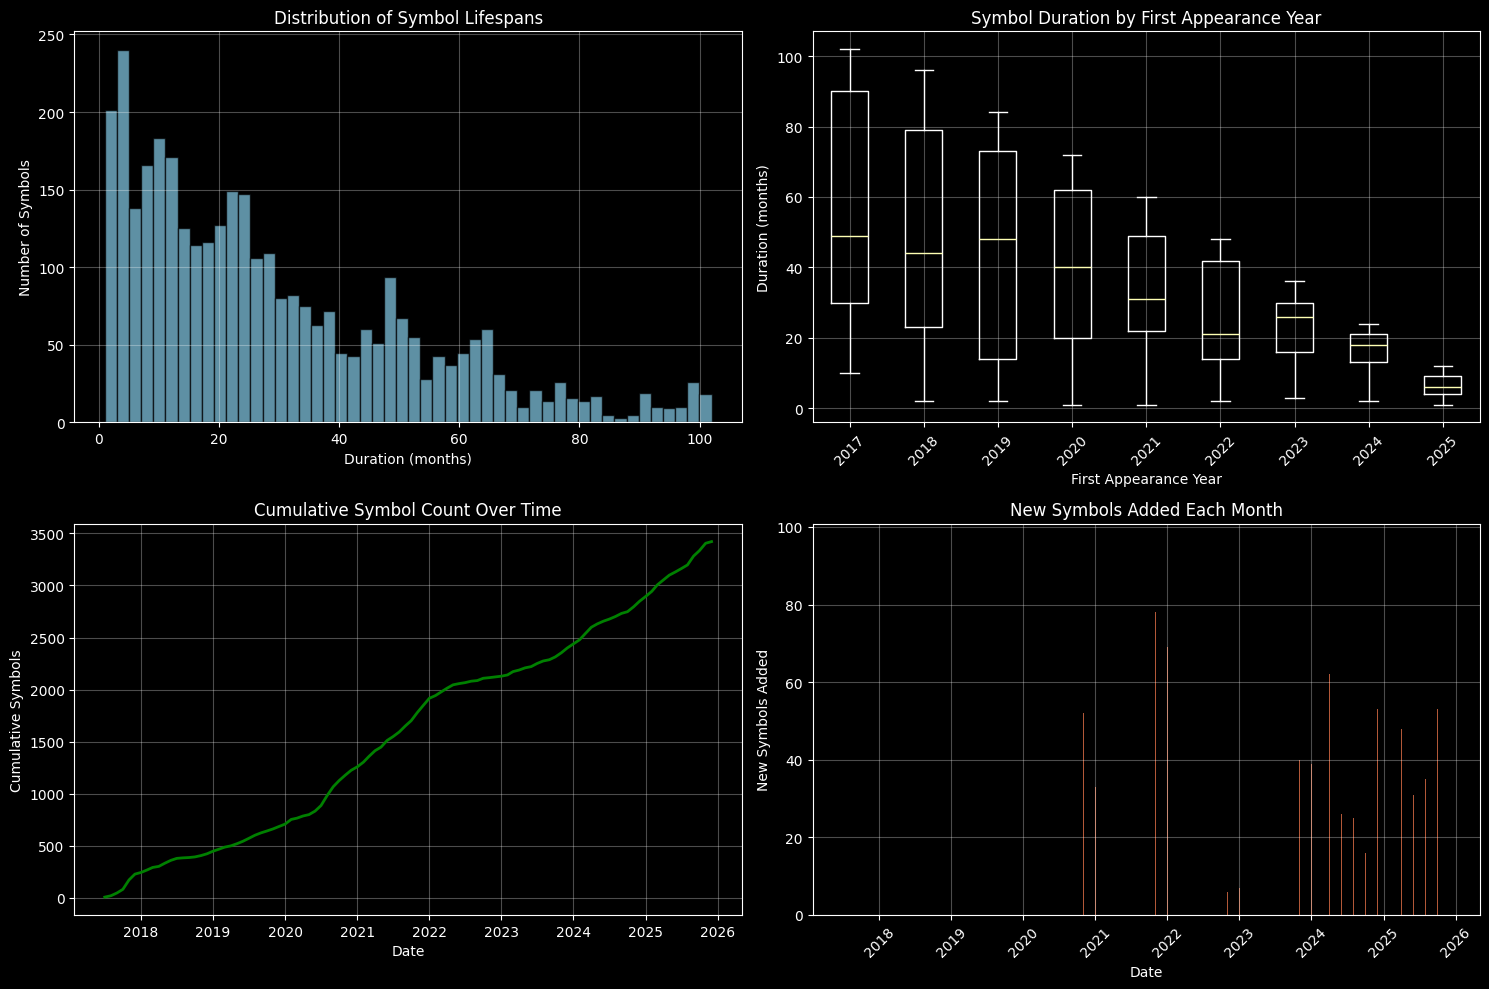

=== TOP 10 LONGEST-RUNNING SYMBOLS ===
ETHBTC       | 102 months | 2017-07 to 2025-12
NEOBTC       | 102 months | 2017-07 to 2025-12
LTCBTC       | 102 months | 2017-07 to 2025-12
BNBBTC       | 102 months | 2017-07 to 2025-12
QTUMETH      | 102 months | 2017-07 to 2025-12
GASBTC       | 101 months | 2017-08 to 2025-12
BNBETH       | 101 months | 2017-08 to 2025-12
ETHUSDT      | 101 months | 2017-08 to 2025-12
BTCUSDT      | 101 months | 2017-08 to 2025-12
LRCETH       | 100 months | 2017-09 to 2025-12

=== MARKET GROWTH PHASES ===
High growth periods (>20% monthly increase): 5
Top growth periods:
  2017-08: +162.5% (21 symbols)
  2017-09: +128.6% (48 symbols)
  2017-11: +111.0% (173 symbols)
  2017-10: +70.8% (82 symbols)
  2017-12: +32.4% (229 symbols)

=== DATA QUALITY METRICS ===
Symbols with data gaps (first 50 checked): 2
Symbols with most gaps:
  HSRBTC: 1.0 gap periods out of 14.0 total months
  YOYOBTC: 1.0 gap periods out of 54.0 total months

=== RECENT ACTIVITY (Last 12 mo

In [ ]:
print("=== DATA COVERAGE ANALYSIS ===")

total_possible_entries = len(symbols) * len(dates)
actual_entries = availability.sum().sum()
completeness_rate = (actual_entries / total_possible_entries) * 100

print(f"Total symbols: {len(symbols)}")
print(f"Total time periods: {len(dates)}")
print(f"Possible symbol-month combinations: {total_possible_entries:,}")
print(f"Actual data points: {actual_entries:,.0f}")
print(f"Overall data completeness: {completeness_rate:.2f}%")
print()

print("=== SYMBOL LIFECYCLE ANALYSIS ===")
symbol_lifecycle = symbol_stats.to_pandas()
symbol_lifecycle['duration_months'] = symbol_lifecycle['months']
symbol_lifecycle['years_active'] = symbol_lifecycle['duration_months'] / 12

print(f"Symbols with complete data (all {len(dates)} months): {(symbol_lifecycle['duration_months'] == len(dates)).sum()}")
print(f"Symbols with single month only: {(symbol_lifecycle['duration_months'] == 1).sum()}")
print(f"Average symbol lifespan: {symbol_lifecycle['duration_months'].mean():.1f} months ({symbol_lifecycle['years_active'].mean():.1f} years)")
print(f"Median symbol lifespan: {symbol_lifecycle['duration_months'].median():.1f} months")
print()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.hist(symbol_lifecycle['duration_months'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_xlabel('Duration (months)')
ax1.set_ylabel('Number of Symbols')
ax1.set_title('Distribution of Symbol Lifespans')
ax1.grid(True, alpha=0.3)

symbol_lifecycle['first_year'] = pd.to_datetime(symbol_lifecycle['first_date']).dt.year
yearly_durations = symbol_lifecycle.groupby('first_year')['duration_months'].apply(list).to_dict()
years = sorted(yearly_durations.keys())
duration_data = [yearly_durations[year] for year in years]

bp = ax2.boxplot(duration_data, labels=years)
ax2.set_xlabel('First Appearance Year')
ax2.set_ylabel('Duration (months)')
ax2.set_title('Symbol Duration by First Appearance Year')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(True, alpha=0.3)

cumulative_symbols = []
cumsum = 0
for date in monthly_pd['date']:
    new_symbols = symbol_lifecycle[pd.to_datetime(symbol_lifecycle['first_date']) <= date].shape[0]
    cumulative_symbols.append(new_symbols)

ax3.plot(monthly_pd['date'], cumulative_symbols, color='green', linewidth=2)
ax3.set_xlabel('Date')
ax3.set_ylabel('Cumulative Symbols')
ax3.set_title('Cumulative Symbol Count Over Time')
ax3.grid(True, alpha=0.3)

new_symbols_monthly = []
for i, date in enumerate(monthly_pd['date']):
    if i == 0:
        new_symbols_monthly.append(monthly_pd.iloc[i]['symbols'])
    else:
        prev_symbols = set(symbol_lifecycle[pd.to_datetime(symbol_lifecycle['first_date']) <= monthly_pd.iloc[i-1]['date']]['symbol'])
        curr_symbols = set(symbol_lifecycle[pd.to_datetime(symbol_lifecycle['first_date']) <= date]['symbol'])
        new_count = len(curr_symbols - prev_symbols)
        new_symbols_monthly.append(new_count)

ax4.bar(monthly_pd['date'], new_symbols_monthly, alpha=0.7, color='coral')
ax4.set_xlabel('Date')
ax4.set_ylabel('New Symbols Added')
ax4.set_title('New Symbols Added Each Month')
ax4.grid(True, alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

print("=== TOP 10 LONGEST-RUNNING SYMBOLS ===")
top_symbols = symbol_lifecycle.nlargest(10, 'duration_months')[['symbol', 'duration_months', 'first_date', 'last_date']]
for _, row in top_symbols.iterrows():
    print(f"{row['symbol']:12} | {row['duration_months']:3d} months | {row['first_date']:%Y-%m} to {row['last_date']:%Y-%m}")
print()

print("=== MARKET GROWTH PHASES ===")
monthly_pd['symbols_ma_6'] = monthly_pd['symbols'].rolling(6, center=True).mean()
monthly_pd['growth_rate'] = monthly_pd['symbols'].pct_change() * 100

high_growth_periods = monthly_pd[monthly_pd['growth_rate'] > 20]
print(f"High growth periods (>20% monthly increase): {len(high_growth_periods)}")
if len(high_growth_periods) > 0:
    print("Top growth periods:")
    for _, period in high_growth_periods.nlargest(5, 'growth_rate').iterrows():
        print(f"  {period['date']:%Y-%m}: +{period['growth_rate']:.1f}% ({period['symbols']} symbols)")

print()

print("=== DATA QUALITY METRICS ===")

symbols_with_gaps = []
for symbol in symbols[:50]:
    symbol_data = availability.loc[symbol]
    if symbol_data.sum() > 1:
        consecutive_months = 0
        max_consecutive = 0
        for val in symbol_data:
            if val == 1:
                consecutive_months += 1
                max_consecutive = max(max_consecutive, consecutive_months)
            else:
                consecutive_months = 0
        
        total_months = symbol_data.sum()
        if max_consecutive < total_months:
            gap_count = total_months - max_consecutive
            symbols_with_gaps.append((symbol, gap_count, total_months))

print(f"Symbols with data gaps (first 50 checked): {len(symbols_with_gaps)}")
if symbols_with_gaps:
    print("Symbols with most gaps:")
    for symbol, gaps, total in sorted(symbols_with_gaps, key=lambda x: x[1], reverse=True)[:5]:
        print(f"  {symbol}: {gaps} gap periods out of {total} total months")

print(f"\n=== RECENT ACTIVITY (Last 12 months) ===")
recent_dates = dates[-12:]
recent_activity = availability[recent_dates]
active_recently = (recent_activity.sum(axis=1) > 0).sum()
fully_active_recently = (recent_activity.sum(axis=1) == 12).sum()

print(f"Symbols active in last 12 months: {active_recently}")
print(f"Symbols fully active (all 12 months): {fully_active_recently}")
print(f"Recent activity rate: {(fully_active_recently/len(symbols)*100):.1f}%")